<a href="https://colab.research.google.com/github/ignaciomontovio/TP-Virus/blob/Nacho/TP_EntregableVirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Práctico

#### 01-3900 | Ciencia de datos | 2024

Alumno:

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (PPT/Pdf Árboles de clasificación) o  Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos). Ver TP_AutomatizarTransformaciones.ipynb

En materiales del MIEL se adjunta un notebook que propone algunas ideas para automatizar el proceso.

## Evaluacion final - Docente + Alumno

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder


PRODUCCION = False
best_clf = None #Asignar aqui el mejor clasificador posible (previamente entrenado)

#Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    # df_orig = df
    # _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones


#Evaluación final
#y_pred = best_clf.predict(X_prod)
#print(classification_report(y_prod, y_pred))
# df.shape[0]

## Analisis de Variables

In [78]:
# verificamos los tipos de datos
df.dtypes

Edad       float64
Genero      object
Peso       float64
Laboral     object
hijos        int64
BLD01      float64
REC1       float64
REC2       float64
REC3       float64
REC4       float64
REC5       float64
BLD02      float64
BLD03      float64
LVL        float64
target       int64
dtype: object

In [80]:
# Verificamos si hay valores nulos para imputar
print(df.isnull().sum())
# Verificamos si hay duplicados
print(df.duplicated().sum())

Edad        822
Genero     1682
Peso          0
Laboral       0
hijos         0
BLD01         0
REC1          0
REC2          0
REC3          0
REC4          0
REC5          0
BLD02         0
BLD03         0
LVL         527
target        0
dtype: int64
0


### Correlacion

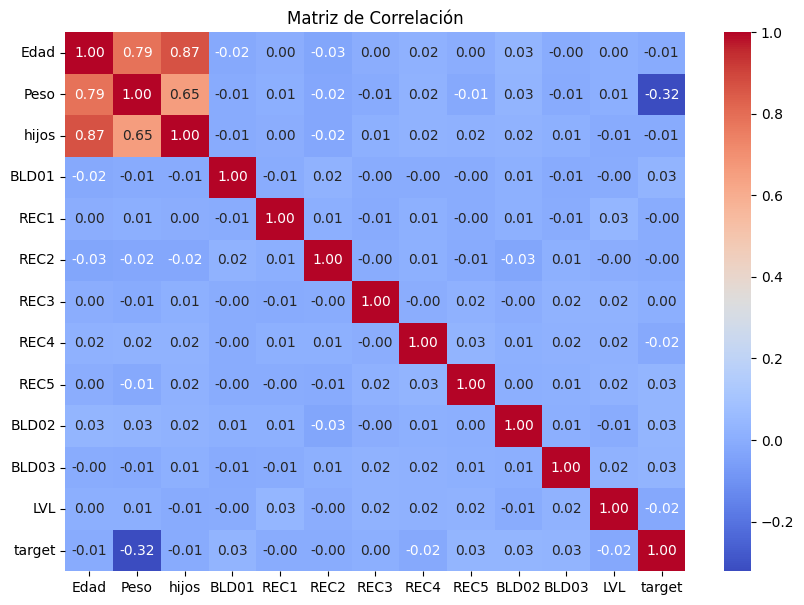

In [81]:
#En la matriz de correlación vemos que edad, peso e hijos estan ampliamente correlacionados.
#Las demas variables no poseen correlacion entre ellas, pueden aportar valor.
fig, ax = plt.subplots(figsize=(10,7))
mat = df.select_dtypes(include=['int', 'float']).corr()
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

### Edad

Edad
16.0    67
65.0    63
72.0    62
15.0    61
7.0     60
        ..
54.0    27
32.0    26
39.0    26
42.0    26
45.0    21
Name: count, Length: 80, dtype: int64


<Axes: xlabel='Edad', ylabel='count'>

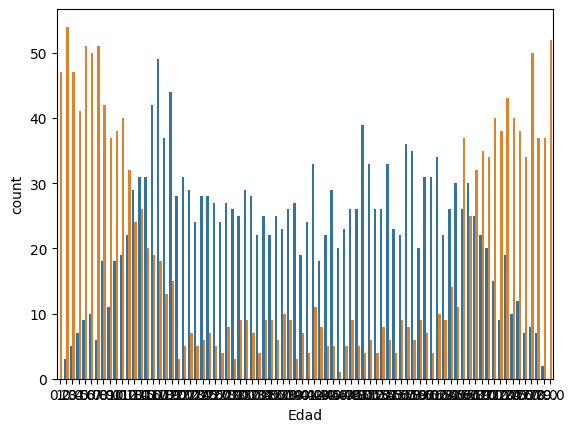

In [108]:
# Analisis de la distribución de la variable target "Edad"
print( df.Edad.value_counts() )
sns.countplot(x='Edad', data=df, hue='target', legend=False)

array([[<Axes: title={'center': 'Edad'}>]], dtype=object)

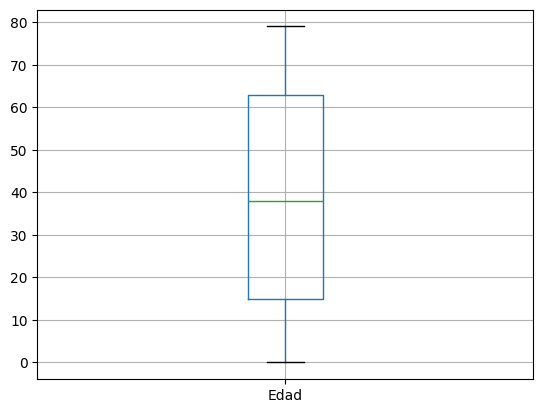

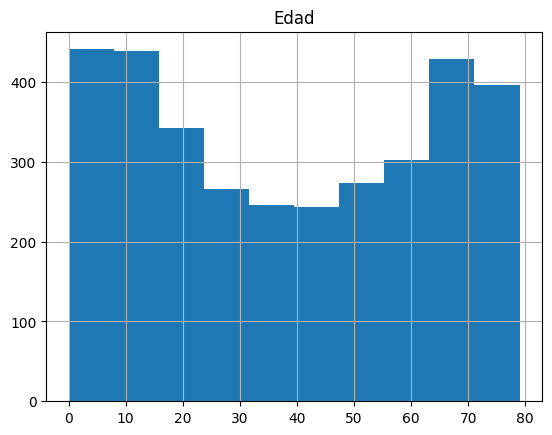

In [109]:
df[["Edad"]].boxplot()
df[["Edad"]].hist()

In [110]:
df[["Edad"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Edad,3378.0,38.658082,25.048819,0.0,15.0,38.0,63.0,79.0


In [111]:
df.Edad.value_counts()

Edad
16.0    67
65.0    63
72.0    62
15.0    61
7.0     60
        ..
54.0    27
32.0    26
39.0    26
42.0    26
45.0    21
Name: count, Length: 80, dtype: int64

### Peso

In [ ]:
df[["Peso"]].boxplot()
df[["Peso"]].hist()

In [ ]:
df[["Peso"]].describe().T

In [ ]:
df.Peso.value_counts()

# Observamos outliers en peso. Los valores atipicos estan relacionados con los recien nacidos, debido a la media del peso de la muestra,
# parece ser un valor fuera de lo normal cuando no lo es. Sin embargo que el peso '8.934178..'
# sea el único que encuentre repetido varias veces es indicativo de un error en la carga o defectos en la muestra.

### Hijos

In [ ]:
# Analisis de la distribución de la variable target "hijos"
print( df.hijos.value_counts() )
sns.countplot(x='hijos', data=df, hue='hijos', legend=False)

df[["hijos"]].boxplot()
df[["hijos"]].hist()

In [ ]:
df[["hijos"]].describe().T

In [ ]:
df.hijos.value_counts()

### BLD01

In [ ]:
df[["BLD01"]].boxplot()
df[["BLD01"]].hist(bins=30)

In [ ]:
df[["BLD01"]].describe().T

In [ ]:
df.BLD01.value_counts()

### BLD02

In [ ]:
df[["BLD02"]].boxplot()
df[["BLD02"]].hist()

In [ ]:
df[["BLD02"]].describe().T

In [ ]:
print(df.BLD02.value_counts())

### BLD03

In [ ]:
df[["BLD03"]].boxplot()
df[["BLD03"]].hist()

In [ ]:
df[["BLD03"]].describe().T

In [ ]:
df.BLD03.value_counts()

### REC1

In [ ]:
df[["REC1"]].boxplot()
df[["REC1"]].hist()

In [ ]:
df[["REC1"]].describe().T

In [ ]:
df.REC1.value_counts()

### REC2

In [ ]:
df[["REC2"]].boxplot()
df[["REC2"]].hist()

In [ ]:
df[["REC2"]].describe().T

In [ ]:
df.REC2.value_counts()

### REC3

In [ ]:
df[["REC3"]].boxplot()
df[["REC3"]].hist()

In [ ]:
df[["REC3"]].describe().T

In [ ]:
df.REC3.value_counts()

### REC4

In [ ]:
df[["REC4"]].boxplot()
df[["REC4"]].hist()

In [ ]:
df[["REC4"]].describe().T

In [ ]:
df.REC4.value_counts()

### REC5

In [ ]:
df[["REC5"]].boxplot()
df[["REC5"]].hist()

In [ ]:
df[["REC5"]].describe().T

In [ ]:
df.REC5.value_counts()

### Target

<Axes: xlabel='target', ylabel='count'>

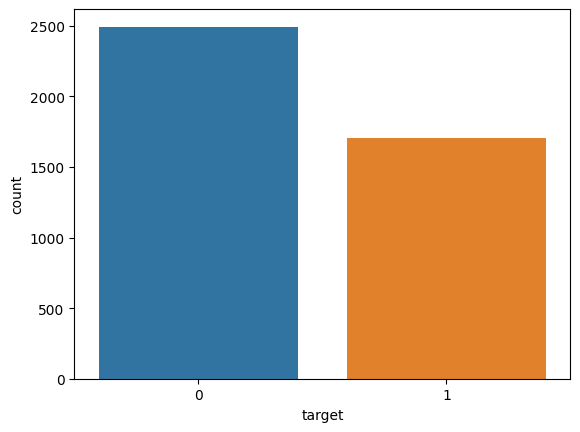

In [60]:
sns.countplot(x='target', data=df, hue='target', legend=False)

### Capacidad Predictiva de variables

In [8]:
df_corr = df.drop(['Genero','Laboral'],axis=1).corr()[["target"]]*100 # lo pasamos a porcentajes
df_corr = df_corr.drop("target", axis=0) # eliminamos la variable target
df_corr = abs(df_corr) # nos interesa el valor absouluto
df_corr = df_corr.sort_values(["target"], ascending=False) # ordenamos en forma descendente
df_corr

,target
Peso,32.198189
REC5,3.166885
BLD02,3.083032
BLD03,2.831029
BLD01,2.628072
LVL,1.935375
REC4,1.518718
hijos,1.199386
Edad,0.847261
REC3,0.455189


### Conclusiones y preguntas

Las variables BLD01, BLD02, BLD03, REC1, REC2, REC3, REC4 y REC5, tienen outliers casi en ambos extremos, dice en el enunciado que estas variables fueron alteradas en sus valores para preservar la privacidad de las personas. Quizas eso afecto su distribución?
Estoy dudando si eliminarlas o tratarlas porque las variables Peso y LVL tambien muestran outliers pero en sus limites inferiores. Que se explica con que la muestra contiene recien nacidos y personas muy jovenes, por lo que no creo que se necesite tratarlas.

In [ ]:
#No hay duplicados.
print("Cantidad:",  df.duplicated().sum())

## Tratamiento de variables

Aca vamos a tratar cosas generales que queremos aplicar siempre, luego en la evaluacion del modelo,
con los pipelines probamos y analiamos distintas estragias de imputacion, normalizacion, etc...

In [149]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Separa los datos en conjuntos completos y faltantes
df_completo = df.dropna()
df_faltante = df[df['Edad'].isnull()]

# Entrena un modelo de regresión utilizando las columnas correlacionadas como predictoras
modelo = LinearRegression()
modelo.fit(df_completo[['Peso', 'hijos']], df_completo['Edad'])

# Predice los valores faltantes
valores_predichos = modelo.predict(df_faltante[['Peso', 'hijos']])

# Asigna los valores predichos de vuelta al DataFrame original
df.loc[df['Edad'].isnull(), 'Edad'] = valores_predichos
df['Edad'] = df['Edad'].astype(int)
df

,Edad,Genero,Peso,Laboral,hijos,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,target
0,9,Femenino,36.410602,Inactivo,0,3.139714,6.929112,63.712640,73.880613,15.087239,90.400193,2.015331,1.633836,51.411632,0
1,58,Masculino,115.507184,Inactivo,4,2.953914,4.660136,64.582610,73.669319,14.503106,90.817947,0.973317,-0.439358,1000000.000000,0
2,74,Masculino,81.249035,Activo,3,1.365200,3.005861,63.613454,75.103984,14.077988,91.741638,3.243344,0.380413,1000000.000000,1
3,24,Masculino,77.985589,No_declara,0,2.329285,4.344642,64.433115,73.402436,15.583846,91.741709,3.188290,-0.226046,NaN,0
4,1,Femenino,13.446208,Inactivo,0,-0.062975,3.938741,65.122602,75.007982,16.961593,90.668625,2.729202,0.589698,21.627303,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,45,NaN,90.221760,Activo,1,1.660127,2.720841,64.551161,74.409061,15.196857,90.130661,0.936022,0.292744,112.514342,0
4196,9,Masculino,37.949680,Inactivo,0,2.001270,3.892882,64.271080,71.905067,15.192511,89.164612,2.887523,0.694750,1000000.000000,1
4197,24,Masculino,72.322983,Activo,1,1.598071,5.566376,65.217362,70.912155,15.975612,89.835998,-0.490912,1.572128,100.452789,1
4198,16,NaN,56.321757,Inactivo,0,1.804688,3.494108,61.385971,74.595457,14.696368,91.129958,1.937261,0.428380,82.772516,0


In [ ]:
def preparacion_de_datos(df_input, target, escalar_valores=False):
  df = df_input
  if escalar_valores:
    scaler_X = StandardScaler(with_mean=True, with_std=True)
    scaler_X.fit(df.drop(target,axis=1))
    x = pd.DataFrame(scaler_X.transform(df.drop(target,axis=1),), columns = df.drop(target,axis=1).columns )
  else:
    x = df.drop(target,axis=1)
  y = df[target]
  return x,y

## Utilidades - Imputacion

In [4]:
def graficarCurvaRoc( y_pred, model ):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  # Graficamos
  plt.plot(fpr,tpr,label= model +" AUC="+str(round(auc,4))) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)
  return auc

In [6]:
# Para automatizar la imputacion y hacerlo mas rapido y simple
# Nos va a servir para probar rapido distintas strategias de imputacion, encoding, normalizacion
# Y ver cual es la mejor.

class ColImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(), columns=[]):
        super().__init__()
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()

    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(Xc[self.columns])
        return Xc

class ColEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=None, columns=[]):
        super().__init__()
        self.encoder = encoder
        self.columns = columns

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.get_feature_names_out()

    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.encoder.transform(Xc[self.columns])
        return Xc

class ColScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler(), columns=[]):
        super().__init__()
        self.scaler = scaler
        self.columns = columns

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self

    def get_feature_names_out(self):
        return self.scaler.get_feature_names_out()

    def  transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.scaler.transform(Xc[self.columns])
        return Xc

class ColDummy(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], delete = ''):
        super().__init__()
        self.columns = columns
        self.delete = delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        Xc = pd.get_dummies(Xc, columns=self.columns)
        if(self.delete != ''):
          Xc = Xc.drop(columns=self.delete)
        #Xc = X.drop(columns=self.columns)
        return Xc

class ReplaceValue(BaseEstimator, TransformerMixin):
    def __init__(self, column, old_value, new_value):
        self.column = column
        self.old_value = old_value
        self.new_value = new_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.column] = Xc[self.column].replace(self.old_value, self.new_value)
        return Xc

## Evaluacion de modelos

### Balanceo

Esto es algo que probamos para mejorar igualar los scores de las metricas (para 0 y 1)
Finalmente decidimos ir por cambiar el parametro scoring en grid search por accuracy

In [74]:
df_norm = df
X = df_norm.drop("target", axis=1).drop("hijos", axis=1)
y = df_norm["target"]

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Calcular el número de muestras de la clase minoritaria y mayoritaria
minority_class_count = y.value_counts().min()
majority_class_count = y.value_counts().max()
print(minority_class_count)
print(majority_class_count)


# Definir los pasos de la pipeline
over_sampler = RandomOverSampler(random_state=42)
under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.8)

# Crear la pipeline combinando oversampling y undersampling
pipeline = Pipeline(steps=[('under', under_sampler), ('over', over_sampler)])

# Aplicar la pipeline al conjunto de datos
X_resampled, y_resampled = pipeline.fit_resample(X, y)
minority_class_count = y_resampled.value_counts().min()
majority_class_count = y_resampled.value_counts().max()
print(minority_class_count)
print(majority_class_count)

1707
2493
1707
1707


### Pipelines

#### P1 - Sin peso ni REC5

In [150]:
df_norm = df
df_norm.loc[df['LVL'] == 1000000, 'LVL'] = None
# Reemplazar los valores NaN por 'Desconocido' en Genero
df_norm["Genero"].fillna('Desconocido', inplace=True)


X = df_norm.drop("target", axis=1).drop("Peso", axis=1).drop("REC5", axis=1)
y = df_norm["target"]

X_train_norm, X_test_norm, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)

pl = Pipeline(steps=[
    ("LVLImputer", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["LVL"])),
    ("LaboralDummies", ColDummy(columns=["Laboral"])),
    ("GeneroDummies", ColDummy(columns=["Genero"], delete='Genero_Desconocido')),
    ("BLD03Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD03"])),
    ("BLD02Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD02"])),
    ("BLD01Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD01"])),
    ("LVLScaler", ColScaler(scaler=MinMaxScaler(), columns=["LVL"]))
])

pl.fit(X_train_norm, y_train)
X_train = pl.transform(X_train_norm)
X_test = pl.transform(X_test_norm)

X_train

1707
2493
2133
2133


,Edad,hijos,BLD01,REC1,REC2,REC3,REC4,BLD02,BLD03,LVL,Laboral_Activo,Laboral_Inactivo,Laboral_No_declara,Genero_Femenino,Genero_Masculino,Genero_Otro
2133,74,3,0.502340,3.005861,63.613454,75.103984,14.077988,0.829255,0.518279,0.606886,True,False,False,False,True,False
1444,37,1,0.549376,5.183180,62.911193,73.287970,13.329870,0.664813,0.473057,0.812804,False,False,True,False,False,False
3691,47,1,0.507659,5.317858,65.430135,74.977653,13.379614,0.798819,0.582809,0.807023,True,False,False,False,False,False
2102,66,3,0.561955,4.646176,63.392451,72.623325,15.224558,0.666032,0.565330,0.694723,False,False,True,False,False,False
551,73,3,0.753070,2.730679,62.982256,73.746035,13.763374,0.631675,0.630402,0.660441,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,18,0,0.403691,4.047474,62.970757,73.141479,14.323235,0.601097,0.549122,0.606886,False,True,False,False,False,False
968,23,0,0.666556,3.250144,62.751774,73.780217,12.465445,0.715625,0.615475,0.505691,True,False,False,False,False,False
1667,34,1,0.666235,4.856991,64.803364,72.175810,16.466500,0.473898,0.377264,0.768185,True,False,False,False,True,False
3321,6,0,0.643543,3.303899,62.962840,73.338127,13.556594,0.828458,0.223641,0.459999,False,True,False,False,True,False


#### P2 - Sin hijos

In [65]:
df_norm = df
df_norm.loc[df['LVL'] == 1000000, 'LVL'] = None

#df_norm = df_norm[df_norm['Edad'] > 10]
#df_norm = df_norm[df_norm['Peso'] != 8.934178194834107]

#df_norm = df_norm.drop(columns=['edad'])

# Reemplazar los valores NaN por 'Desconocido' en Genero
df_norm["Genero"].fillna('Desconocido', inplace=True)


# Reemplazar los valores NaN por 'Desconocido' en Edad
#df_norm["Edad"].fillna('Desconocido', inplace=True)

X = df_norm.drop("target", axis=1).drop("hijos", axis=1)
y = df_norm["target"]

X_train_norm, X_test_norm, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)

pl = Pipeline(steps=[
    ("LVLImputer", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["LVL"])),
    ("EdadImputer", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["Edad"])),
    ("LaboralDummies", ColDummy(columns=["Laboral"])),
    ("GeneroDummies", ColDummy(columns=["Genero"], delete='Genero_Desconocido')),
    ("BLD03Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD03"])),
    ("BLD02Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD02"])),
    ("BLD01Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD01"])),
    ("LVLScaler", ColScaler(scaler=MinMaxScaler(), columns=["LVL"]))
])

pl.fit(X_train_norm, y_train)
X_train = pl.transform(X_train_norm)
X_test = pl.transform(X_test_norm)

X_train

1707
2493
2493
2493


,Edad,Peso,BLD01,REC1,REC2,REC3,REC4,REC5,BLD02,BLD03,LVL,Laboral_Activo,Laboral_Inactivo,Laboral_No_declara,Genero_Femenino,Genero_Masculino,Genero_Otro
1799,37.000000,89.226027,0.360204,4.251919,62.757164,72.915246,13.964558,91.007198,0.591310,0.503046,0.639360,False,True,False,False,True,False
1390,63.000000,78.418911,0.292517,4.950209,65.018187,75.313108,15.440935,90.271600,0.655245,0.662900,0.733159,False,True,False,False,True,False
163,38.698357,106.827484,0.464720,5.069041,63.986987,72.908855,15.127451,90.721601,0.663741,0.386236,0.766999,False,True,False,False,True,False
2257,12.000000,42.060850,0.522211,5.338595,64.531436,71.876420,14.603989,90.025707,0.424992,0.556497,0.603092,False,True,False,False,True,False
2819,7.000000,31.156069,0.401363,2.498901,63.933110,72.464518,14.672774,89.119885,0.537928,0.590059,0.252601,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,33.000000,89.263552,0.447036,4.861519,62.723841,72.990709,15.699700,88.944602,0.501739,0.408874,0.603092,True,False,False,False,True,False
968,30.000000,74.282078,0.499312,4.181098,62.936434,74.113698,16.940356,90.913767,0.633786,0.544144,0.650954,True,False,False,False,False,False
1667,51.000000,91.684094,0.503052,4.542602,63.700422,73.861100,15.546783,89.154361,0.204723,0.215020,0.603092,False,False,True,False,False,False
3321,78.000000,80.601930,0.528789,4.757968,63.495781,73.130045,15.907796,88.565129,0.394308,0.601292,0.631282,False,True,False,False,True,False


### Armado de modelos y obtencion de precision (Sin GridSearch)

In [151]:
logreg = LogisticRegression( max_iter=3000 )
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)

treeclf = DecisionTreeClassifier(max_depth=10, random_state=1)
treeclf.fit(X_train, y_train)
y_pred_tc = treeclf.predict(X_test)

bayes_multi = MultinomialNB()
bayes_multi.fit(X_train, y_train)
y_pred_nb = bayes_multi.predict(X_test)

bayes_gauss = GaussianNB()
bayes_gauss.fit(X_train, y_train)
y_pred_gauss = bayes_gauss.predict(X_test)

,model,auc
1,arbol,0.747343
0,bayesGauss,0.700402
2,reglog,0.682021
3,multinomial,0.577082


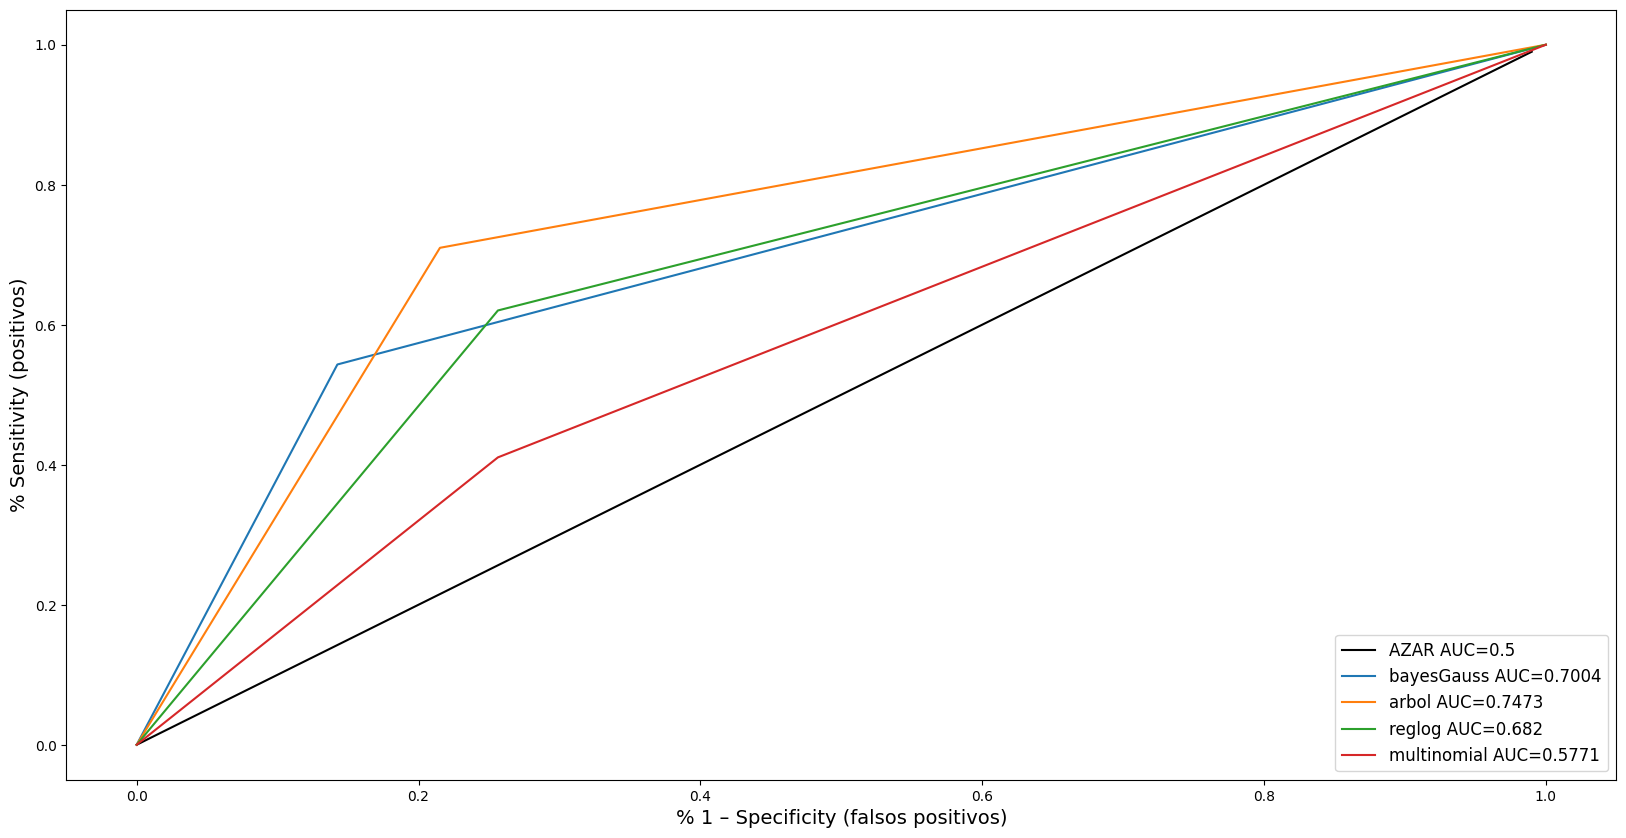

In [152]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = { 'bayesGauss':y_pred_gauss,'arbol':y_pred_tc, 'reglog':y_pred_lg, 'multinomial': y_pred_nb}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Grafico
# plt.title("Curva ROC", fontsize=14)
# plt.tick_params(labelsize=12);
# plt.show()
# Tabla
areas.sort_values('auc', ascending=False)

In [153]:
from IPython.display import display, Markdown

display(Markdown(f"## LogisticRegression"))
print(classification_report(y_test, y_pred_lg))

display(Markdown(f"## DecisionTreeClassifier"))
print(classification_report(y_test, y_pred_tc))

display(Markdown(f"## MultinomialNB"))
print(classification_report(y_test, y_pred_nb))

display(Markdown(f"## GaussianNB"))
print(classification_report(y_test, y_pred_gauss))


## LogisticRegression

              precision    recall  f1-score   support

           0       0.66      0.74      0.70       632
           1       0.71      0.62      0.66       648

    accuracy                           0.68      1280
   macro avg       0.68      0.68      0.68      1280
weighted avg       0.68      0.68      0.68      1280



## DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       632
           1       0.77      0.71      0.74       648

    accuracy                           0.75      1280
   macro avg       0.75      0.75      0.75      1280
weighted avg       0.75      0.75      0.75      1280



## MultinomialNB

              precision    recall  f1-score   support

           0       0.55      0.74      0.63       632
           1       0.62      0.41      0.49       648

    accuracy                           0.57      1280
   macro avg       0.59      0.58      0.56      1280
weighted avg       0.59      0.57      0.56      1280



## GaussianNB

              precision    recall  f1-score   support

           0       0.65      0.86      0.74       632
           1       0.80      0.54      0.65       648

    accuracy                           0.70      1280
   macro avg       0.72      0.70      0.69      1280
weighted avg       0.72      0.70      0.69      1280



## Mejora de los modelos con GridSearch

### Logistic Regression

In [154]:
from warnings import simplefilter
# ignore all warnings
simplefilter(action='ignore')

# Con todas las opciones de solver no converge nunca
# "solver": ['saga', 'sag', 'newton-cholesky', 'newton-cg', 'liblinear', 'lbfgs']

parameters =  {"C":np.logspace(-3,3,13), "penalty":["l1","l2",None], "max_iter":[1500,3000,4000]}
clf = GridSearchCV( LogisticRegression() , parameters, scoring='accuracy', cv=5, )
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
lg_best = clf.best_estimator_

Best Parameters: {'C': np.float64(10.0), 'max_iter': 1500, 'penalty': 'l2'}
Best Score: 0.6738088435488478


### KNN

In [155]:
parameters = {"criterion": ['gini', 'entropy', 'log_loss'], "splitter": ['best', 'random'], "max_depth": [2, 5, 10, 20, 30, 40], "random_state": [1,5,9,15,20,30,40]}
clf = GridSearchCV( DecisionTreeClassifier() , parameters, scoring='accuracy', cv=5, )
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
knn_best = clf.best_estimator_

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'random_state': 5, 'splitter': 'best'}
Best Score: 0.7642280521895991


### Multinomial

In [156]:
parameters = {"fit_prior": [True, False], "alpha": [0,1.0,2.0,3.0], "force_alpha": [True, False]}
clf = GridSearchCV( MultinomialNB() , parameters, scoring='accuracy', cv=5, )
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
mnb_best = clf.best_estimator_

Best Parameters: {'alpha': 0, 'fit_prior': True, 'force_alpha': True}
Best Score: 0.574017803622348


### GaussianNB

In [157]:
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
clf = GridSearchCV( GaussianNB() , parameters, scoring='accuracy', cv=5, )
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)
print("Best Score:", clf.best_score_)
gnb_best = clf.best_estimator_

Best Parameters: {'var_smoothing': np.float64(0.1873817422860384)}
Best Score: 0.7397858859514966


,model,auc
1,arbol,0.743427
0,bayesGauss,0.722525
2,reglog,0.679764
3,multinomial,0.577082


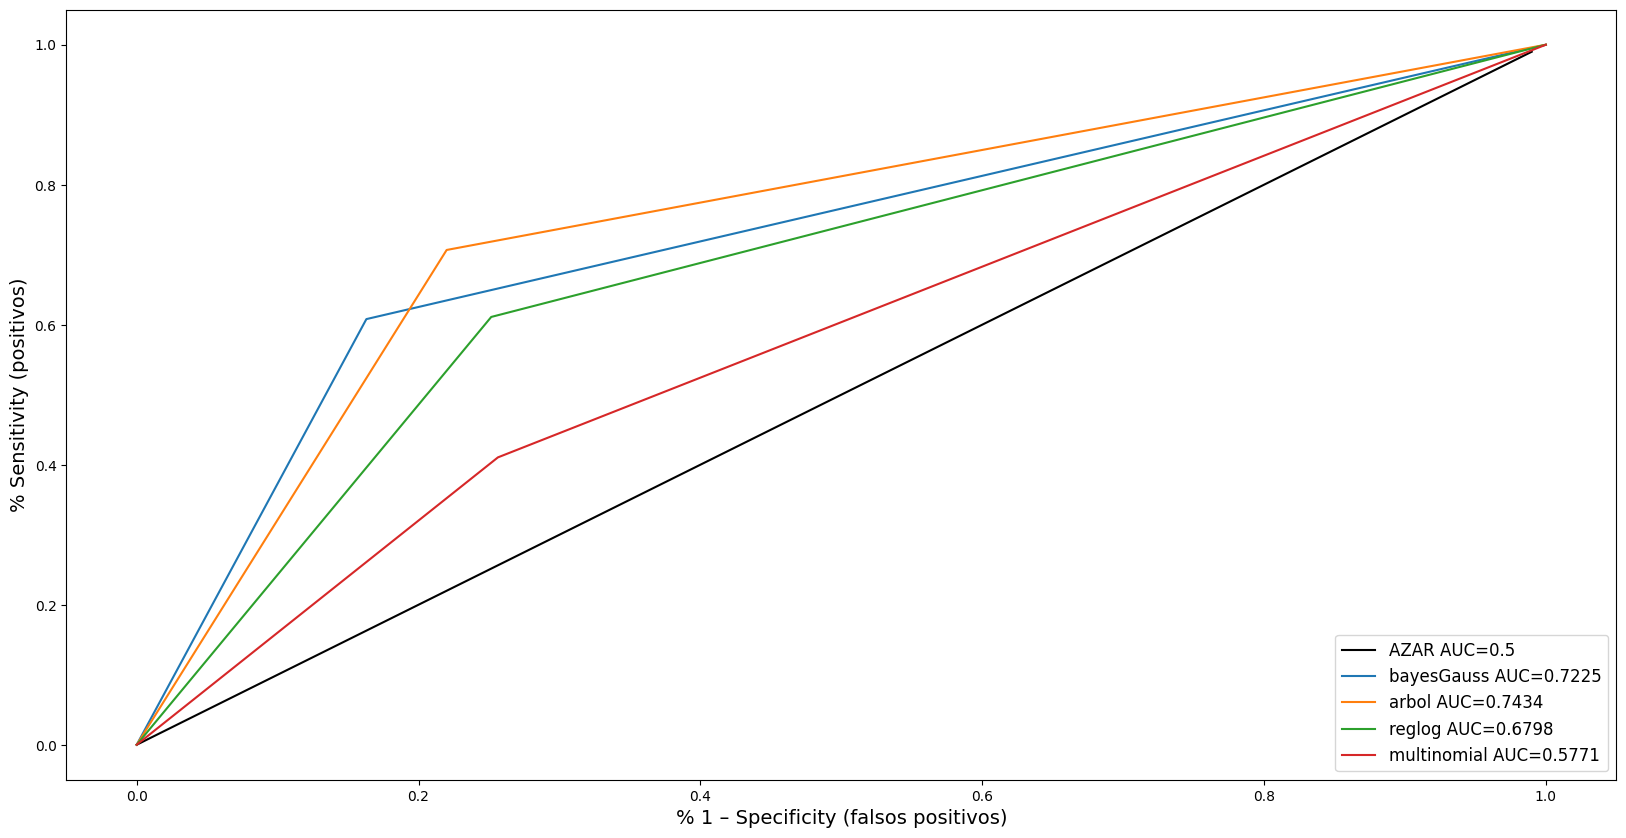

In [158]:
lg_best.fit(X_train, y_train)
y_pred_lg = lg_best.predict(X_test)

knn_best.fit(X_train, y_train)
y_pred_tc = knn_best.predict(X_test)

mnb_best.fit(X_train, y_train)
y_pred_nb = mnb_best.predict(X_test)

gnb_best.fit(X_train, y_train)
y_pred_gauss = gnb_best.predict(X_test)

plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = { 'bayesGauss':y_pred_gauss,'arbol':y_pred_tc, 'reglog':y_pred_lg, 'multinomial': y_pred_nb}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])
# Grafico
# plt.title("Curva ROC", fontsize=14)
# plt.tick_params(labelsize=12);
# plt.show()
# Tabla
areas.sort_values('auc', ascending=False)

In [159]:
from IPython.display import display, Markdown

display(Markdown(f"## LogisticRegression"))
print(classification_report(y_test, y_pred_lg))

display(Markdown(f"## DecisionTreeClassifier"))
print(classification_report(y_test, y_pred_tc))
# Mejora bastante pero me baja mucho el 1

display(Markdown(f"## MultinomialNB"))
print(classification_report(y_test, y_pred_nb))

display(Markdown(f"## GaussianNB"))
print(classification_report(y_test, y_pred_gauss))

## LogisticRegression

              precision    recall  f1-score   support

           0       0.65      0.75      0.70       632
           1       0.71      0.61      0.66       648

    accuracy                           0.68      1280
   macro avg       0.68      0.68      0.68      1280
weighted avg       0.68      0.68      0.68      1280



## DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       632
           1       0.77      0.71      0.74       648

    accuracy                           0.74      1280
   macro avg       0.74      0.74      0.74      1280
weighted avg       0.74      0.74      0.74      1280



## MultinomialNB

              precision    recall  f1-score   support

           0       0.55      0.74      0.63       632
           1       0.62      0.41      0.49       648

    accuracy                           0.57      1280
   macro avg       0.59      0.58      0.56      1280
weighted avg       0.59      0.57      0.56      1280



## GaussianNB

              precision    recall  f1-score   support

           0       0.68      0.84      0.75       632
           1       0.79      0.61      0.69       648

    accuracy                           0.72      1280
   macro avg       0.73      0.72      0.72      1280
weighted avg       0.73      0.72      0.72      1280



## Validación

Para garantizar la robustez y la generalización de nuestro modelo utilizaremos la técnica de validación cruzada (K-Folds). Esto nos permitirá evaluar el rendimiento del modelo de manera más exhaustiva.

La validación cruzada nos ayudará a reducir el sesgo de evaluación,Además nos permitirá identificar la variabilidad en el rendimiento del modelo, minimizando así el riesgo de sobreajuste (overfitting) y asegurando que el modelo generalice bien a nuevos datos no vistos.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def realizar_kfolds_val(model,X,y,splits=5,shf=True):
    kf = KFold(n_splits=splits, shuffle=shf, random_state=42)

    # Evaluar el modelo utilizando validación cruzada
    scores = cross_val_score(model, X, y, cv=kf)

    print(f'Scores for each fold: {scores}')
    print(f'Mean score: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

print("Cross-Validation - Log Reg")
realizar_kfolds_val(logreg,X_train,y_train,5)

print("\n\nCross-Validation - Decision Tree Classifier")
realizar_kfolds_val(treeclf,X_train,y_train,5)

print("\n\nCross-Validation - Multinomial Bayes")
realizar_kfolds_val(bayes_multi,X_train,y_train,5)

print("\n\nCross-Validation - Gaussian Bayes")
realizar_kfolds_val(bayes_gauss,X_train,y_train,5)

## Pendientes:

Ver si podemos balancer la variable target, (todas las metricas nos dab bajas para el caso de positivos)
Tratar las variables faltantes solo estamos haciendo:
("LVLImputer", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["LVL"])),
    ("EdadImputer", ColImputer(imputer=SimpleImputer(strategy='mean'), columns=["Edad"])),
    ("LaboralDummies", ColDummy(columns=["Laboral"])),
    ("GeneroDummies", ColDummy(columns=["Genero"], delete='Genero_Desconocido')),
    ("BLD03Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD03"])),
    ("BLD02Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD02"])),
    ("BLD01Scaler", ColScaler(scaler=MinMaxScaler(), columns=["BLD01"])),
    ("LVLScaler", ColScaler(scaler=MinMaxScaler(), columns=["LVL"]))
Probar otros scalers, strategias etc...
Ver validacion Cruzada
Ver sesgo de seleccion y fuga de datos

en la parte de tratamiento de variables no estamos haciendo nada relevante, hace falta ese scaler a todo el dataset? o podemos tener los scalers del pipeline y ya?
por lo que veo en los colab escala casi siempre todas las variables creo deberiamos hacerlo

en varios colab elige que variables utilizar y cuales no (en base a la correlacion?) ver si eso mejora las metricas